### Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [4]:
connection = Connection()
# Get client
client = connection.get_client()

In [5]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [6]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [7]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
W15 Record count after target preprocessing: 86
W15 Record count after preprocessing: 86
W18 original record count: 89
W18 Record count before target preprocessing: 86
W18 Record count after target preproc

755

In [8]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [32]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=524, Validation=79, Test=152


In [33]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [34]:
def assert_model(hybrid_model):
    assert hasattr(hybrid_model, "_ml_feature_columns")
    assert len(hybrid_model._ml_feature_columns) > 0

    # Feature consistency check
    df_test_lag = hybrid_model._create_lagged_features(df_test).dropna()
    phys_test = hybrid_model.predict_physics(df_test_lag)

    # Feature consistency check
    X_test_df = hybrid_model._build_ml_features(df_test_lag, phys_test)
    assert list(X_test_df[hybrid_model._ml_feature_columns].columns) == hybrid_model._ml_feature_columns

In [36]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)
assert_model(model)

In [37]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.803679767470789,
   'mae': 14.783910599502027,
   'rmse': 17.96003623611553,
   'mape (%)': 15.776989755620702,
   'mpe (%)': 4.0792240629643235},
  'qw': {'r2': 0.16674637029395845,
   'mae': 0.9488661685769508,
   'rmse': 1.0562333260393462,
   'mape (%)': 378.90726899763547,
   'mpe (%)': 339.75246040698295},
  'qg': {'r2': 0.6031622942333059,
   'mae': 2693.0245583512574,
   'rmse': 3261.3591380670255,
   'mape (%)': 19.391932605387943,
   'mpe (%)': -16.950680404458833},
  'wgr': {'r2': -1.8603481081727424,
   'mae': 9.899141262521056e-05,
   'rmse': 0.00014496715634277675,
   'mape (%)': 540.9295096011948,
   'mpe (%)': 508.6238095169397},
  'gor': {'r2': -301.826044167734,
   'mae': 30.535835512651854,
   'rmse': 37.68082843677983,
   'mape (%)': 24.593809806986165,
   'mpe (%)': -15.925100575019464}},
 'W08': {'qo': {'r2': -0.4350117444725443,
   'mae': 12.835623326816838,
   'rmse': 17.41583795468541,
   'mape (%)': 57.49093879830708,
   'mpe (%)': 15.6

In [38]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.9268292266910578,
   'mae': 8.204260973839094,
   'rmse': 10.964617883569439,
   'mape (%)': 7.629154683608454,
   'mpe (%)': -0.04783409482747179},
  'qw': {'r2': -1.418796768574615,
   'mae': 1.378260641658692,
   'rmse': 1.7995791340628917,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.9301246531244775,
   'mae': 900.8626999671064,
   'rmse': 1368.5294540011344,
   'mape (%)': 6.645714459783364,
   'mpe (%)': 0.1350111994256968},
  'wgr': {'r2': -1.5967559267833944,
   'mae': 0.00010831271523213978,
   'rmse': 0.00013812609705945967,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -96.66408933839155,
   'mae': 13.203277993488618,
   'rmse': 21.398891819990098,
   'mape (%)': 10.649705116515552,
   'mpe (%)': 1.346947288488432}},
 'W08': {'qo': {'r2': -0.17882934566797415,
   'mae': 11.29607005694452,
   'rmse': 15.784910243508842,
   'mape (%)': 46.92888950381709,
   'mpe (%)': 4.5027720615246425},
  'qw': {'r2': 0.162620827612779

In [39]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9686801661062089,
   'mae': 5.5309385856468,
   'rmse': 7.1735545260585045,
   'mape (%)': 4.122399017781037,
   'mpe (%)': 4.084942954464438},
  'qw': {'r2': -1.2327088650181088,
   'mae': 1.3250270380952365,
   'rmse': 1.7289694016415078,
   'mape (%)': 97.48589460336657,
   'mpe (%)': -97.48589460336657},
  'qg': {'r2': 0.994811647959845,
   'mae': 337.7676315954293,
   'rmse': 372.9124462826654,
   'mape (%)': 2.4215291649653983,
   'mpe (%)': 2.391015008645947},
  'wgr': {'r2': -1.4434016753472605,
   'mae': 0.00010481642526338025,
   'rmse': 0.00013398544046791755,
   'mape (%)': 97.26002812208769,
   'mpe (%)': -97.26002812208769},
  'gor': {'r2': -2.497338384282931,
   'mae': 2.7291579232541503,
   'rmse': 4.0494184566978175,
   'mape (%)': 2.1732440148303853,
   'mpe (%)': -1.5625077973465178}},
 'W08': {'qo': {'r2': 0.23369476204489958,
   'mae': 7.128651347675979,
   'rmse': 12.726750921347955,
   'mape (%)': 41.4309438536018,
   'mpe (%)': 23.5718195

In [40]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

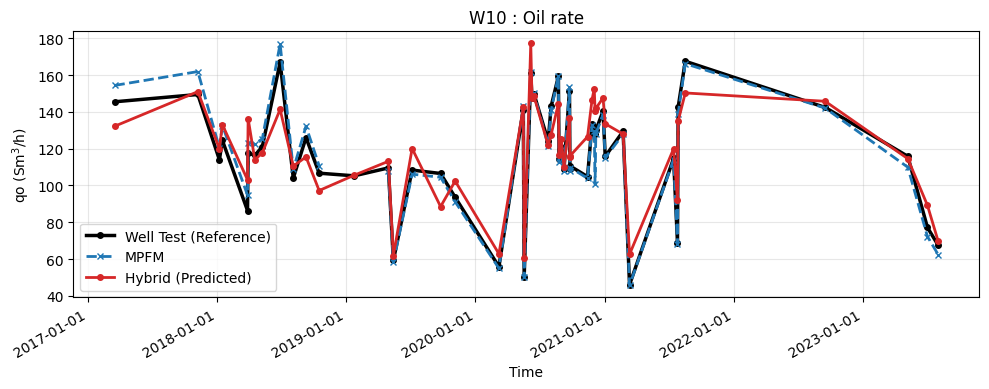

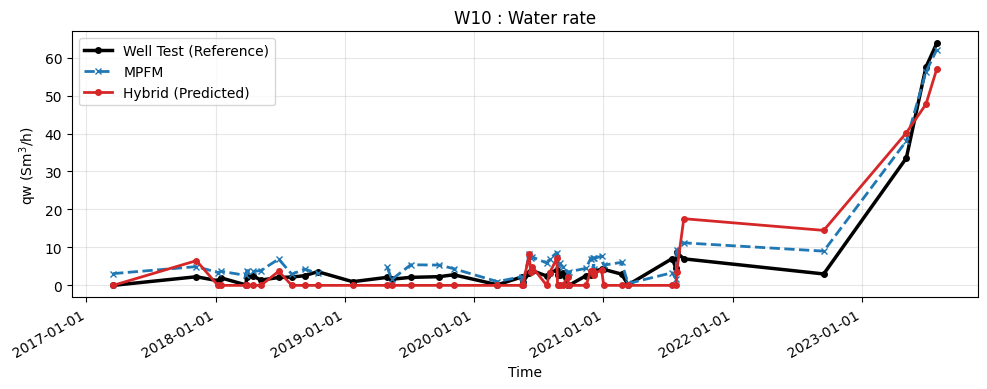

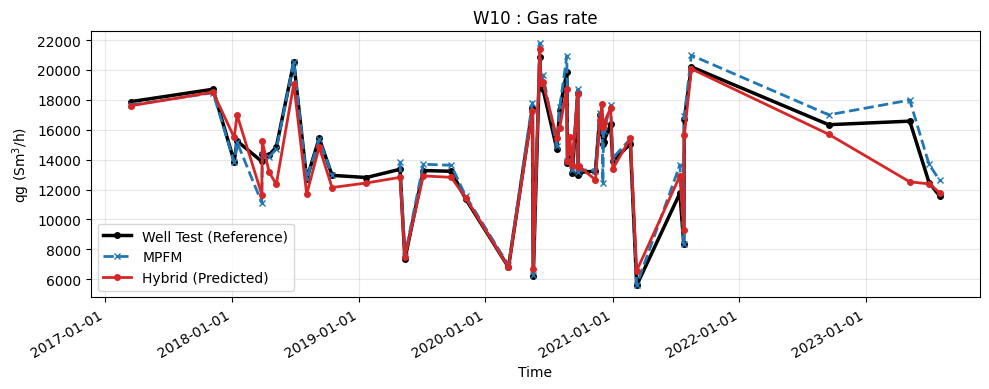

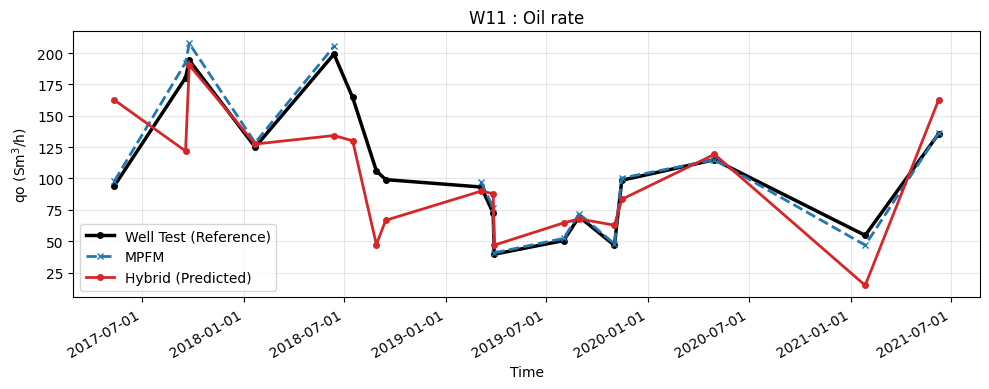

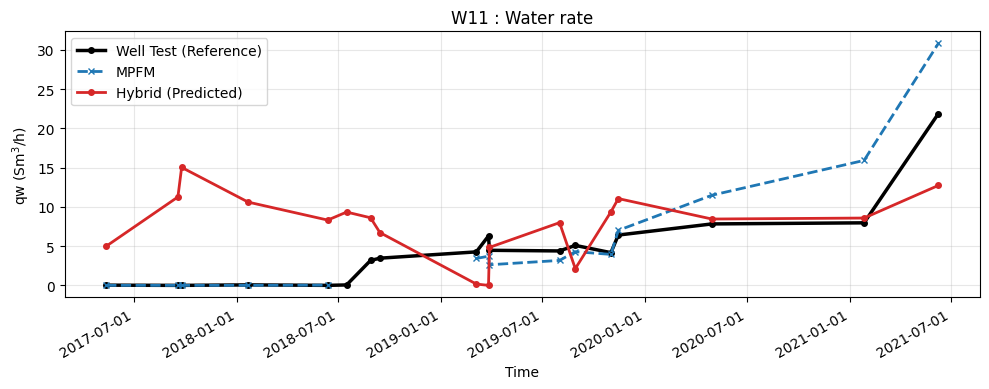

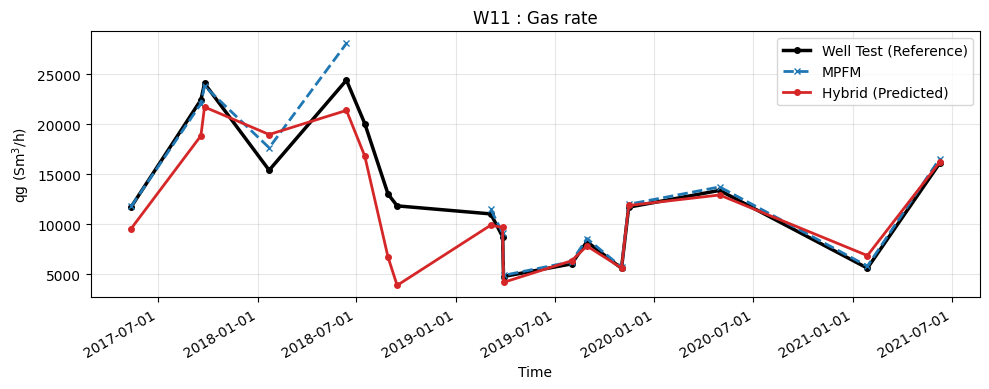

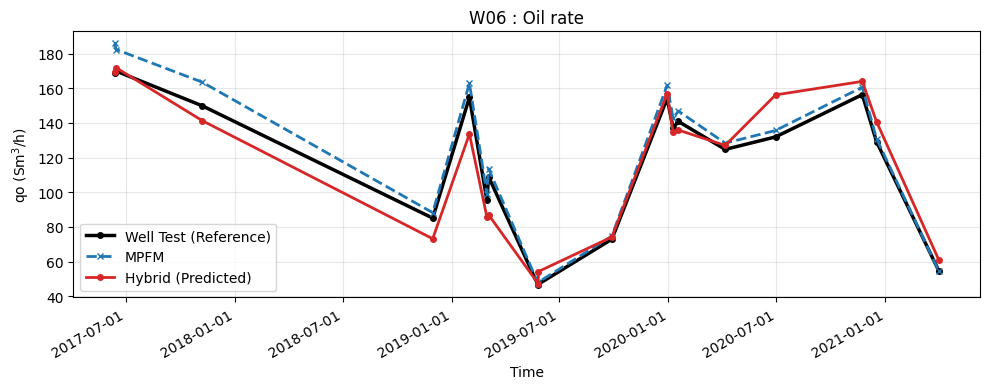

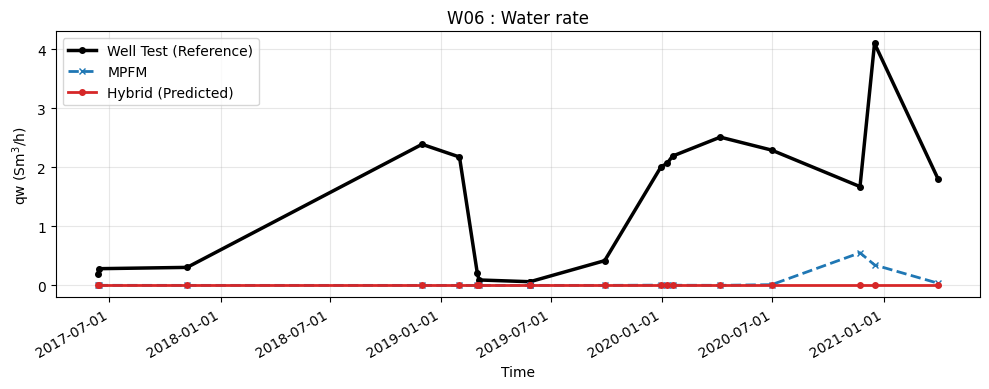

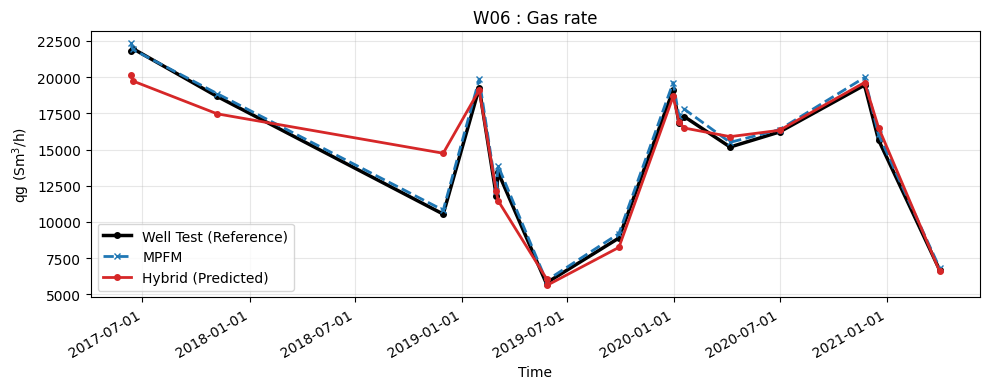

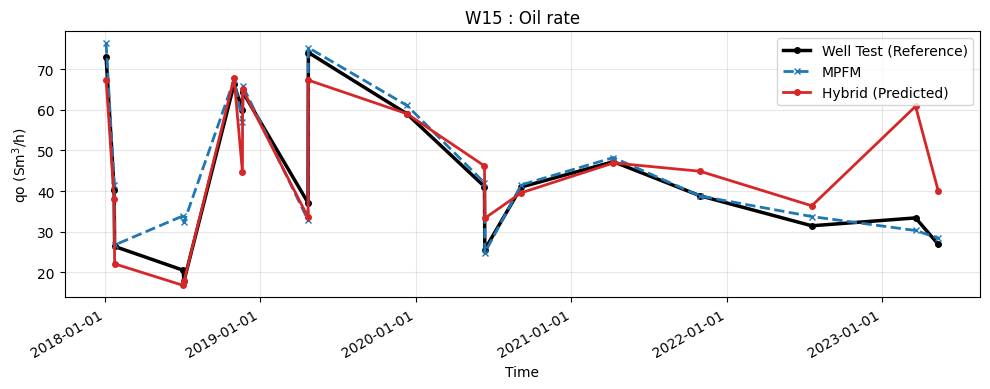

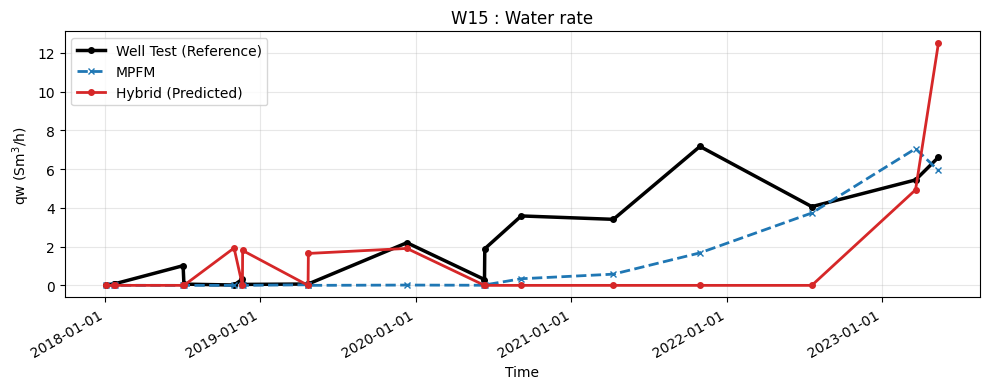

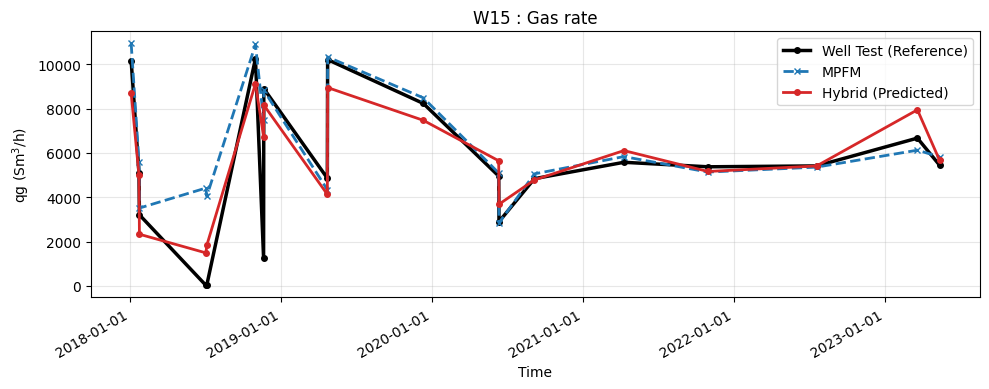

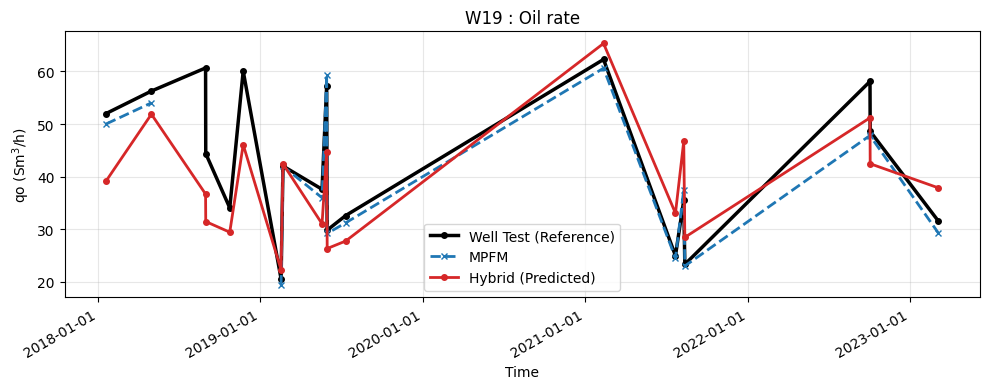

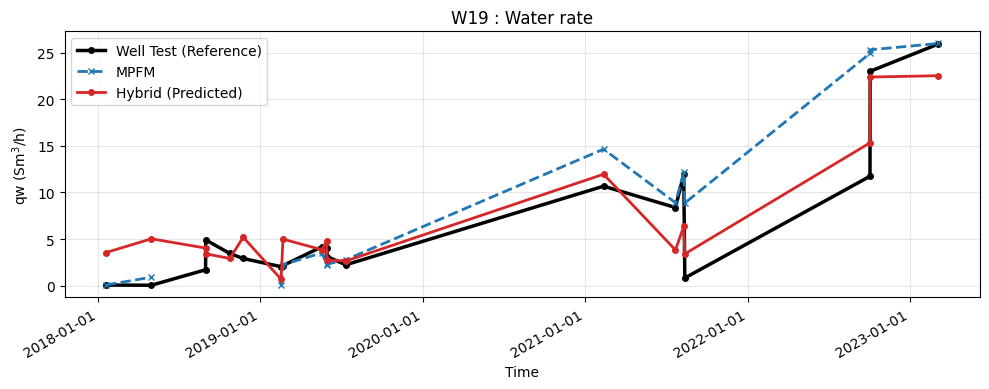

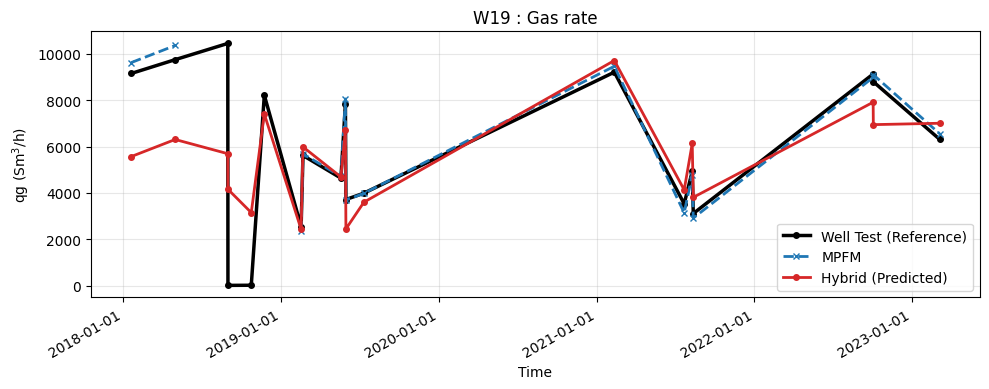

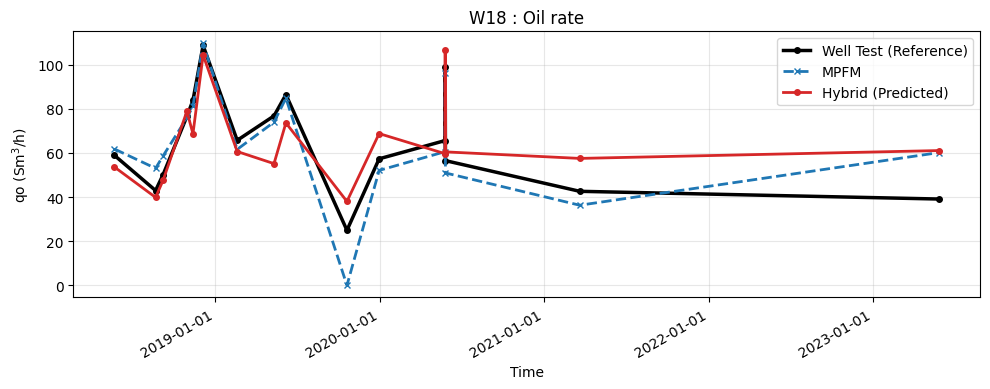

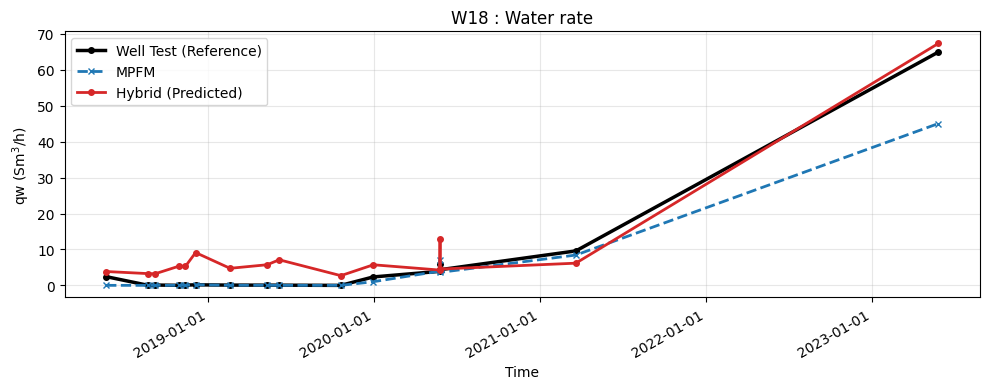

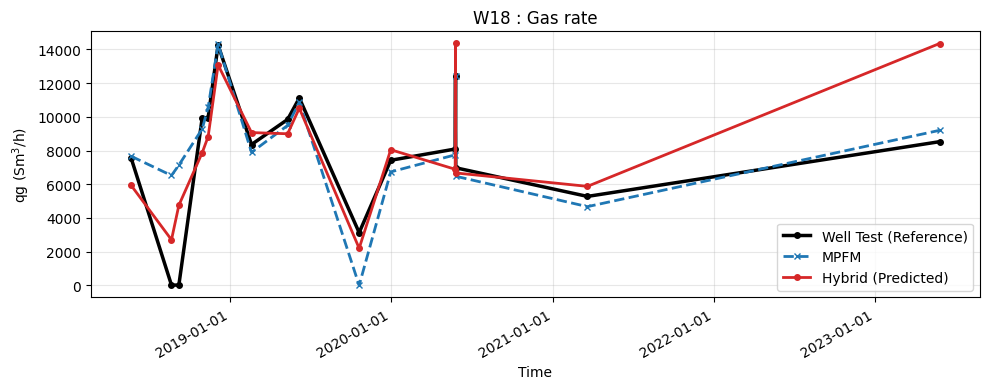

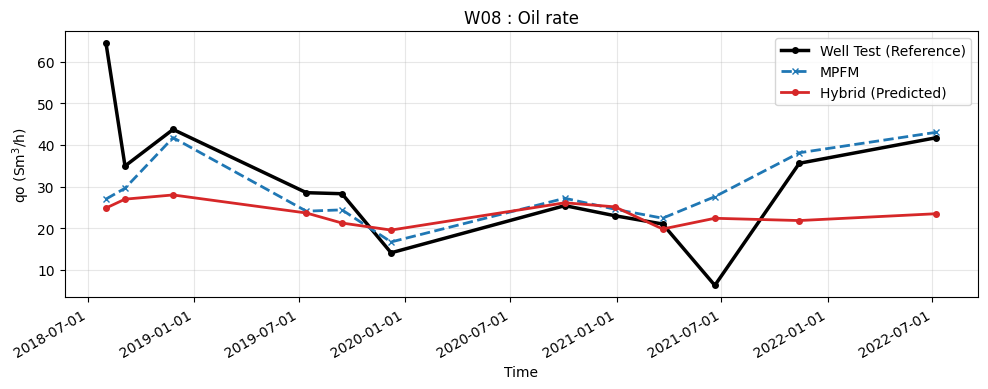

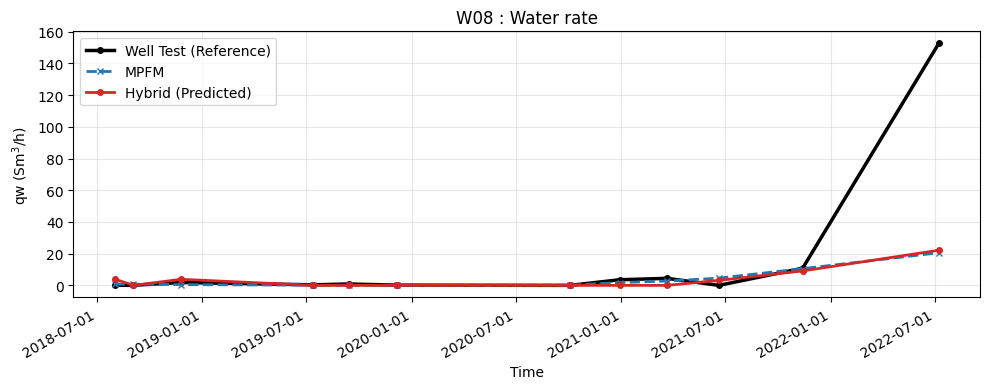

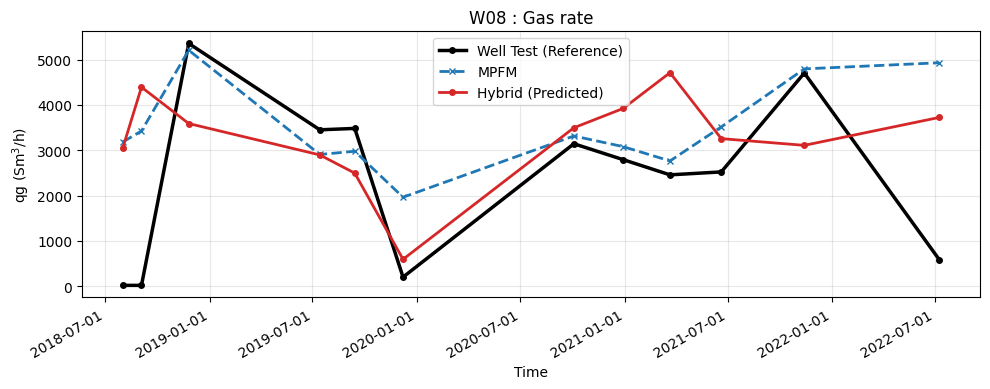

In [41]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [42]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=401, Val=133, Calibration=21, Test=200


In [43]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)



In [44]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [45]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.1728222747016246,
   'mae': 17.828624270064388,
   'rmse': 29.5330718921387,
   'mape (%)': 20.109787445568593,
   'mpe (%)': 15.058561877195844},
  'qw': {'r2': 0.13001868046358434,
   'mae': 3.116025906754907,
   'rmse': 10.081363270692012,
   'mape (%)': 45318.91920872389,
   'mpe (%)': 45281.817257816925},
  'qg': {'r2': 0.46389471955272155,
   'mae': 2293.632807386621,
   'rmse': 3027.928980652917,
   'mape (%)': 339.38575312181575,
   'mpe (%)': 320.03089814719874},
  'wgr': {'r2': 0.031681233781076124,
   'mae': 0.0002758882119867729,
   'rmse': 0.0009357837314466745,
   'mape (%)': 59.693348450009864,
   'mpe (%)': 24.744499454970086},
  'gor': {'r2': -1.9024205462976465,
   'mae': 20.39094113483533,
   'rmse': 27.199232543910526,
   'mape (%)': 235.16331308014986,
   'mpe (%)': 205.71919418000388}}}

In [46]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.535492601299072,
   'mae': 17.552836304329404,
   'rmse': 22.131228644551936,
   'mape (%)': 16.37377107335365,
   'mpe (%)': 14.888197874495852},
  'qw': {'r2': 0.44588785622661564,
   'mae': 3.0430395485219397,
   'rmse': 8.045687026274658,
   'mape (%)': 49860.359595205904,
   'mpe (%)': 49795.26517494125},
  'qg': {'r2': 0.7369195539934463,
   'mae': 1639.300160312149,
   'rmse': 2121.1184762668054,
   'mape (%)': 492.16076518985335,
   'mpe (%)': 490.41930544006254},
  'wgr': {'r2': 0.3027102608377332,
   'mae': 0.00026213759473678566,
   'rmse': 0.0007940958998626412,
   'mape (%)': 56.279042541330284,
   'mpe (%)': -12.09961950533715},
  'gor': {'r2': -0.4554860437599306,
   'mae': 10.88263208329958,
   'rmse': 19.26107414111082,
   'mape (%)': 466.3377692236148,
   'mpe (%)': 455.09230605264463}}}

In [47]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9585683690087083,
   'mae': 3.962391585990041,
   'rmse': 6.634102200238614,
   'mape (%)': 3.308898625885769,
   'mpe (%)': 0.9981948506103846},
  'qw': {'r2': 0.9279800061587495,
   'mae': 2.5038418543053953,
   'rmse': 2.92162451116145,
   'mape (%)': 88235.45905630886,
   'mpe (%)': 88221.31763784771},
  'qg': {'r2': 0.9407993042276998,
   'mae': 516.506669815595,
   'rmse': 1010.0747015838625,
   'mape (%)': 437.3111736941414,
   'mpe (%)': 436.4676096446017},
  'wgr': {'r2': 0.948816158726788,
   'mae': 0.0001733937806012666,
   'rmse': 0.00021680306657369396,
   'mape (%)': 97.54545185451879,
   'mpe (%)': 83.80369620446673},
  'gor': {'r2': 0.13745373778918668,
   'mae': 7.835640295466459,
   'rmse': 14.939652761026956,
   'mape (%)': 444.660131383494,
   'mpe (%)': 440.98480773463376}}}

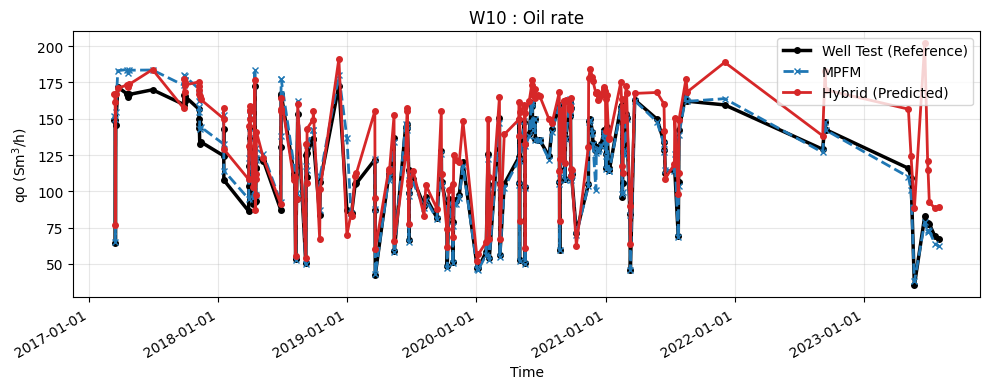

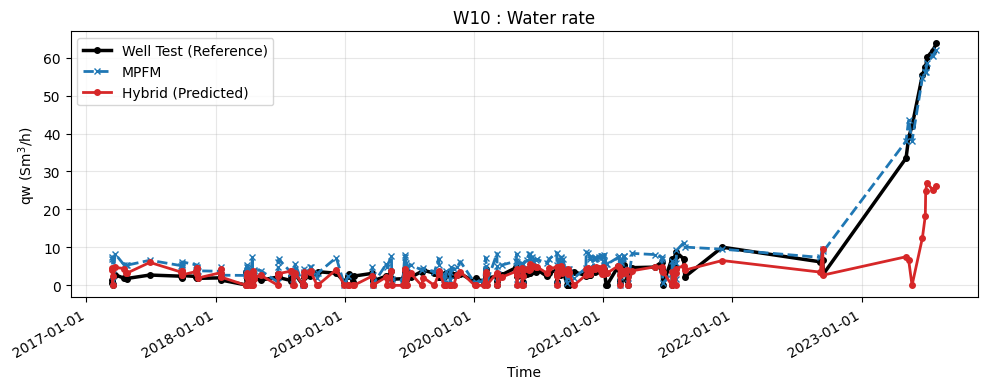

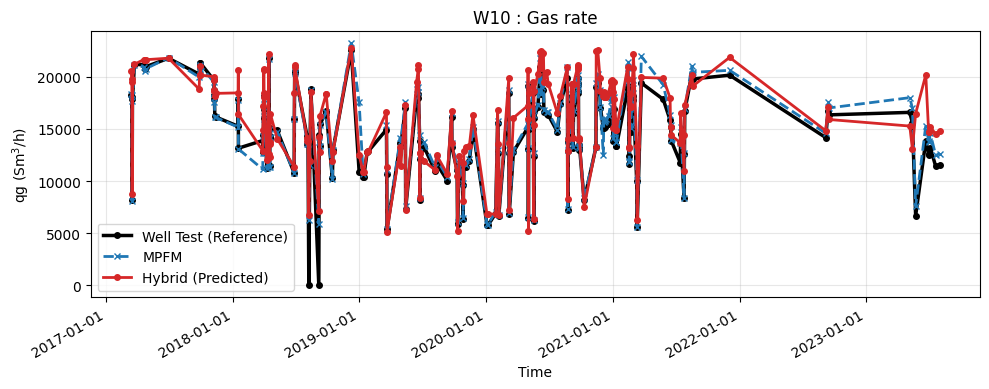

In [48]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [49]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [50]:
# df_resampled.index

In [51]:
# df_resampled.columns

In [52]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [53]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [54]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [55]:
# summarize_null(df_generated)